In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
with open("names.txt", 'r') as file:
    words = file.read().splitlines()
    
chars = sorted(list(set(''.join(words))))
stoi = {char: i + 1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [3]:
vocab_size = len(itos)
block_size = 3
def build_dataset(words):
    X, Y  = [], []
    for w in words:
        context = [0] * block_size
        for char in w + ".":
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:]) 

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [11]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt-t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [5]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd)
# use gain for std (tanh), want to decrease the range between values
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
#give some entropy
b1 = torch.randn((n_hidden, ), generator=g) * 0.01
#to squeeze weights after tanh (-1, 1)
W2 = torch.randn((n_hidden,     vocab_size), generator=g) * 0.1
b2 = torch.randn((vocab_size, ), generator=g) * 0.1

bngain = torch.ones((1, n_hidden))*0.1 + 1
bnbias = torch.zeros((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [6]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [166]:
C

tensor([[-3.8700e-02, -1.9777e-01,  1.5454e+00,  1.2417e+00,  4.9990e-01,
          4.9663e-01, -6.6768e-02,  7.9435e-01, -8.7021e-01, -4.1275e-01],
        [ 1.1483e-01,  6.6377e-01, -3.0242e+00,  9.1265e-01, -1.4273e+00,
         -2.6405e-01,  2.2195e+00, -3.4689e-01,  1.9075e+00, -1.0667e+00],
        [-4.1723e-01,  3.8515e-01, -1.0463e-02,  5.9111e-01,  1.0727e+00,
          4.4170e-01,  7.4894e-01, -6.2405e-01, -1.1541e+00, -7.8524e-01],
        [ 1.4077e+00,  1.0648e+00,  2.3300e-01,  1.0695e+00,  4.8724e-01,
         -1.3592e+00,  1.2244e+00, -6.7369e-01,  4.8945e-01, -4.0883e-01],
        [ 3.5175e-01,  1.3398e+00,  4.8587e-01,  1.4105e+00, -1.1020e+00,
          3.6968e-01,  5.5604e-02,  1.4178e+00, -7.0146e-01, -1.3898e+00],
        [-5.1080e-01,  1.3649e+00,  4.8332e-01, -9.2978e-01, -6.3111e-02,
          1.5390e+00,  1.7124e+00,  1.1401e-01,  4.1286e-02,  3.0185e-01],
        [ 1.5540e+00,  1.3510e+00, -1.2481e+00, -1.0654e+00, -1.8914e+00,
         -5.9529e-01,  6.7441e-0

In [165]:
Xb[:5]

tensor([[ 0,  5,  9],
        [14,  1, 26],
        [ 0,  0,  0],
        [19, 20,  9],
        [ 5, 12,  9]])

In [160]:
emb.shape, C[Xb].shape

(torch.Size([32, 3, 10]), torch.Size([32, 3, 10]))

In [180]:
emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.5101, grad_fn=<NegBackward0>)

In [181]:
h.shape, W2.shape

(torch.Size([32, 64]), torch.Size([64, 27]))

In [182]:
bndiff2.shape, bnvar.shape, dbndiff2.shape

(torch.Size([32, 64]), torch.Size([1, 64]), torch.Size([32, 64]))

In [183]:
dbnvar.shape, bndiff2.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [184]:
dlogprobs = torch.zeros_like((logprobs))
dlogprobs[range(n), Yb] = -1.0/n

dprobs = 1.0 / probs * dlogprobs

dcounts_sum_inv = (counts * dprobs).sum(axis=1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = -1.0 * (counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts #de^x/dx = e^x

#c31, c32, c33 = a31, a32, a33 - b3 = a31 - b3, a32 - b3, a33 - b3
dlogit_maxes = (-torch.ones_like(logits) * dnorm_logits).sum(axis=1, keepdim=True)
dlogits = torch.ones_like(logits) * dnorm_logits
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0, keepdim=True)

dhpreact = (1 - h**2) * dh

dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

dbnvar = (-(bnvar + 1e-5)**-1.5)/2 * dbnvar_inv
dbndiff2 = torch.ones_like(bndiff2)/(n-1) * dbnvar
dbndiff += 2*bndiff*dbndiff2

dhprebn = torch.ones_like(hprebn) * dbndiff
dbnmeani = (-torch.ones_like(bnmeani) * dbndiff).sum(0, keepdim=True)
dhprebn += torch.ones_like(hprebn)/n * dbnmeani

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdim=True)

demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)

cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [185]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

In [186]:
cmp('dlogits', dlogits, logits)

dlogits         | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


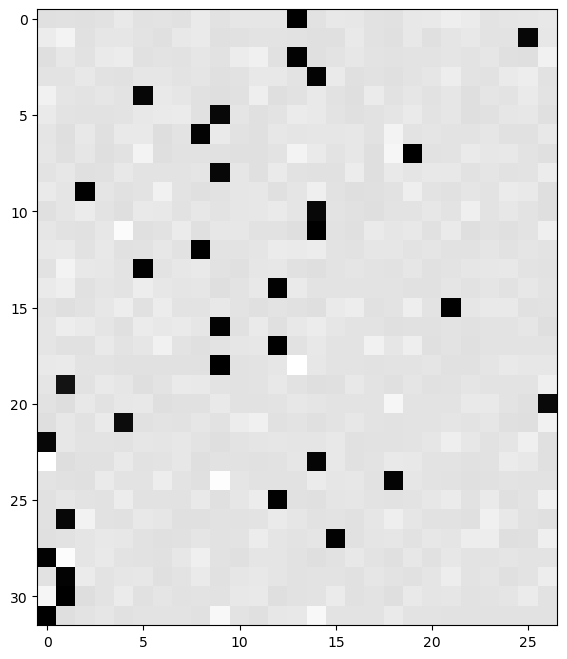

In [189]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [195]:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True))/torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [197]:
dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) -n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
